# Assignment 2 - Recurrent Neural Network Dynamics 

This coursework is a study of how well a recurrent networo model of primary visual cortex (V1) can represent specific features (we will use the example of orientation) of a brief visual stimulus, in the face of readout noise, depending on its connectivity.

We will begin with the experimental set up:

## Technical Set Up

In [4]:
import numpy as np
import matplotlib.pyplot as plt

## Experimental Set Up

### Default Parameters

In [58]:
tau = 20 # characteristic neuron time constant (in ms)

m = 200 # number of regularly spaced orientations

n = 200 # number of neuronal inputs

B = np.eye(m,n) # feedforward input weights

C = np.eye(m,n) # matrix of output weights

sigma = 1 # noise of readout activity 

k = np.pi/4 # encoder constant

alpha = 0.9 # recurrent connection strength constant 1

alpha_dash = 0.9 # recurrent connection strength constant 2

phi = 2 * np.pi * np.linspace(0,1,m) # grid of regularly spaced parameters

dt = 1 # timestep (in ms)

### Default Functions

In [59]:
# Tuning Function
def V(z):
    return np.exp( (np.cos(z)-1) * k**(-2))


# Input Encoding Function
def h(theta):
    return V(phi-theta)


# Euler Discretised Update Function
def update_r(r_t, t, W, B, h_theta, tau, dt):
    delta_input = (B @ h_theta) / dt if t == 0 else 0
    drdt = -r_t + W @ r_t + delta_input
    return r_t + (dt/tau) * drdt


# Noisy Readout of V1 Activity
def o_tilde(C, r_t, sigma):
    noise = np.random.normal(0,1, size = len(r_t))
    return C @ r_t + sigma * noise 


# Noisy Readout Decoding
def theta_hat(phi, o_tilde):
    x = np.sum(o_tilde * np.sin(phi))
    y = np.sum(o_tilde * np.cos(phi))
    return np.arctan2(y,x)


# Circular Distance 
def d(theta_hat, theta):
    return np.arccos(np.cos(theta_hat-theta))

# Rescale matrix W_raq to the spectral radius equals alpha
def R(W_raw, alpha):
    eigvals = np.linalg.eigvals(W_raw)
    spectral_radius = np.max(np.abs(eigvals))
    return (alpha / spectral_radius) * W_raw

## Overall Simulation Code

In [60]:
def run_simulation(theta, phi, time_steps, W, B, C, sigma, tau, dt, k):
    np.random.seed(69)

    # --- Local functions ---
    def V(z):
        return np.exp((np.cos(z) - 1) * k**(-2))

    def h(theta):
        return V(phi - theta)

    def update_r(r_t, t, W, B, h_theta, tau, dt):
        delta_input = (B @ h_theta) / dt if t == 0 else 0
        drdt = -r_t + W @ r_t + delta_input
        return r_t + (dt / tau) * drdt

    def o_tilde_func(C, r_t, sigma):
        noise = np.random.normal(0, 1, size=len(r_t))
        return C @ r_t + sigma * noise

    def theta_hat_func(phi, o_tilde):
        x = np.sum(o_tilde * np.sin(phi))
        y = np.sum(o_tilde * np.cos(phi))
        return np.arctan2(y, x)

    def circ_dist(theta_hat, theta):
        return np.arccos(np.cos(theta_hat - theta))

    # --- Main simulation ---
    h_model = h(theta)
    r_list = [np.zeros(W.shape[0])]

    for i, time in enumerate(time_steps):
        r = update_r(r_list[i], time, W, B, h_model, tau, dt)
        r_list.append(r)

    o_tilde_list = [o_tilde_func(C, r, sigma) for r in r_list]
    theta_hat_list = [theta_hat_func(phi, ot) for ot in o_tilde_list]
    circ_d_list = [circ_dist(th, theta) for th in theta_hat_list]

    return circ_d_list, theta_hat_list, o_tilde_list, r_list


## Different Models of Recurrence

### **Model 1: no recurrence**
For this model, $n = m$ and $W^{(1)} = 0_m$ (the $m \times m$ matrix full of zeros).

---

### **Model 2: random symmetric connectivity**
For this model, $n = m$ and  
$$
W^{(2)} = \mathcal{R}(\tilde{W} + \tilde{W}^\top, \alpha)
$$  
with $\tilde{W}_{ij} \sim \mathcal{N}(0, 1)$ i.i.d.  
The random weights will be generated once and for all before any simulation of the network dynamics with various $\theta$'s.

---

### **Model 3: symmetric ring structure**
For this model, $n = m$ and  
$$
W^{(3)} = \mathcal{R}(\tilde{W}, \alpha)
$$  
with $\tilde{W}_{ij} = \mathcal{V}(\phi_i - \phi_j)$, where $\{ \phi_i \}$ and $\mathcal{V}(\cdot)$ have been defined previously.

---

### **Model 4: balanced ring structure**
For this model, $n = 2m$, and  
$$
W^{(4)} = 
\begin{pmatrix}
\tilde{W} & -\tilde{W} \\
\tilde{W} & -\tilde{W}
\end{pmatrix}
$$  
with $\tilde{W}_{ij} = \mathcal{R}(W^{(3)}, \alpha')$.  
As $n = 2m$, we can no longer use $B = C = I$ as in Table 1. Instead, we use:

$$
B = \begin{pmatrix} I_m \\ 0_m \end{pmatrix}, \quad 
C = (I_m, 0_m)
$$

where $I_m$ denotes the $m \times m$ identity matrix.


## Questions and Experiments

### Question 1 - Integrating the Dynamics of the 4 different Models

In [61]:
theta = np.pi # Input orientation 
time_steps = [0,20,60] # Time steps through which we integrate 

#### Model 1: No Recurrence

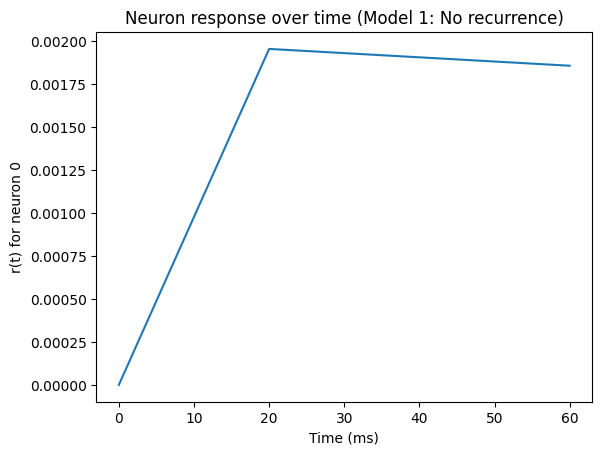

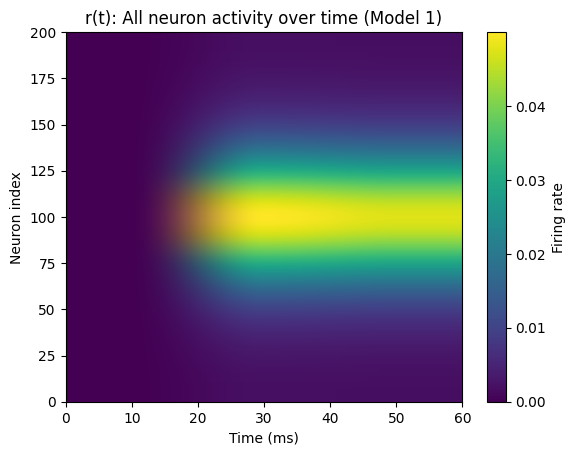

In [75]:
# --- Model 1: No recurrence ---
W_1 = np.zeros_like(B)  # Zero recurrent weights

# Run the simulation
circ_d_w1, theta_hat_list_w1, o_tilde_list_w1, r_list_w1 = run_simulation(
    theta, phi, time_steps, W_1, B, C, sigma, tau, dt, k
)

# Plot response of a single neuron over time
neuron_index = 0
r_values_w1 = [r[neuron_index] for r in r_list_w1[:-1]]  # Exclude final unused timestep
plt.plot(time_steps, r_values_w1)
plt.xlabel("Time (ms)")
plt.ylabel(f"r(t) for neuron {neuron_index}")
plt.title("Neuron response over time (Model 1: No recurrence)")
plt.show()

# Heatmap for all neurons
r_array_w1 = np.array(r_list_w1[:-1])  # shape (time, neurons)
plt.imshow(r_array_w1.T, aspect='auto', origin='lower', extent=[0, time_steps[-1], 0, r_array_w1.shape[1]])
plt.colorbar(label="Firing rate")
plt.xlabel("Time (ms)")
plt.ylabel("Neuron index")
plt.title("r(t): All neuron activity over time (Model 1)")
plt.show()


#### Model 2: Random Symmetric Connectivity

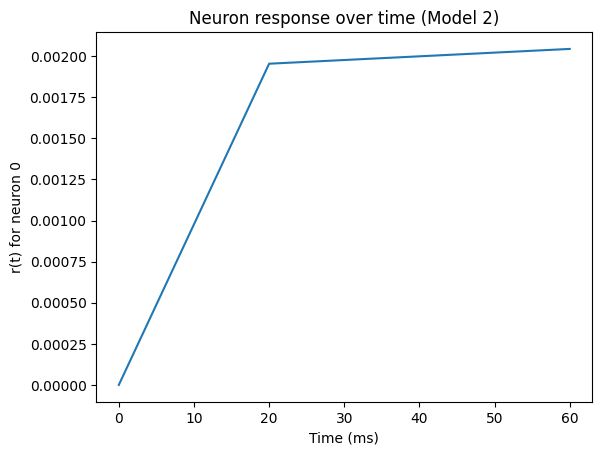

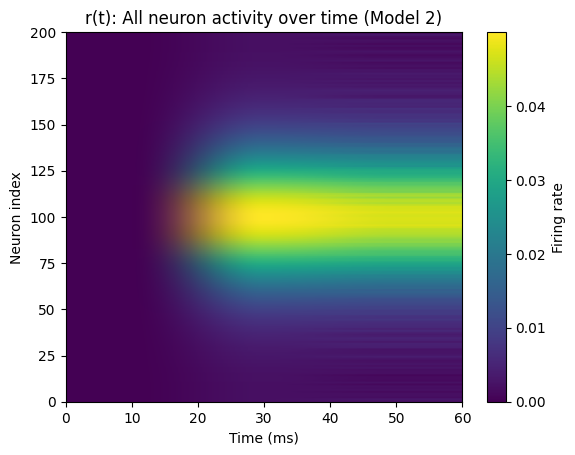

In [73]:
# Model 2: Random symmetric connectivity
W_tilde = np.random.normal(0, 1, size=B.shape)
W_2 = R(W_tilde + W_tilde.T, alpha)

# Run the simulation for theta = π
theta = np.pi
circ_d_w2, theta_hat_list_w2, o_tilde_list_w2, r_list_w2 = run_simulation(
    theta, phi, time_steps, W_2, B, C, sigma, tau, dt, k
)

# Plot neuron 0's response over time
neuron_index = 0
r_values = [r[neuron_index] for r in r_list_w2[:-1]]
plt.plot(time_steps, r_values)
plt.xlabel("Time (ms)")
plt.ylabel(f"r(t) for neuron {neuron_index}")
plt.title("Neuron response over time (Model 2)")
plt.show()

# Plot full r(t) as heatmap
r_array = np.array(r_list_w2[:-1])
plt.imshow(r_array.T, aspect='auto', origin='lower', extent=[0, time_steps[-1], 0, r_array.shape[1]])
plt.colorbar(label="Firing rate")
plt.xlabel("Time (ms)")
plt.ylabel("Neuron index")
plt.title("r(t): All neuron activity over time (Model 2)")
plt.show()
